## **<center>Spam comment filter using Naive Bayes Classifier**



In this notebook, I will be creating a spam filter using multinomial naive bayes algorithm without sci-kit learn, to filter out spam comments from Youtube videos.
We have data of labelled youtube comments in five seperate files. So we'll train our model with four of them and use the fifth file for prediction and testing for accuracy. 
The data set used in this notebook can be found [here](https://www.kaggle.com/prashant111/youtube-spam-collection)

In [1]:
all_files=["Youtube01-Psy.csv","Youtube02-KatyPerry.csv","Youtube03-LMFAO.csv","Youtube04-Eminem.csv"]

In [2]:
list_=[]
import pandas as pd
for file_ in all_files:
    frame = pd.read_csv(("/content/drive/My Drive/Google colab data/Youtube spam/"+file_),index_col=None, header=0)
    list_.append(frame)

# concatenate all dfs into one
df = pd.concat(list_, ignore_index=True)

In [3]:
df

COMMENT_ID  ... CLASS
0     LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU  ...     1
1     LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A  ...     1
2     LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  ...     1
3             z13jhp0bxqncu512g22wvzkasxmvvzjaz04  ...     1
4             z13fwbwp1oujthgqj04chlngpvzmtt3r3dw  ...     1
...                                           ...  ...   ...
1581  LneaDw26bFu3RCmyrWyP9S6wh1h9dBv3X95g1HzKAb4  ...     1
1582  LneaDw26bFsD65dtIvAEObWYIYnFTqQDKBek_Ypz3J8  ...     1
1583  LneaDw26bFuvs-8oWkLpAFa6g3QHpWD8k7sbbMP3Bg8  ...     1
1584        z12hfp2wmyuqztkw504cgblyxtbsxjuzeow0k  ...     0
1585          z13tsbc5vvn0hdozz04chjt51lq1cvris0k  ...     0

[1586 rows x 5 columns]

# Data Cleaning

Since, our aim is to classify comments as spam or not spam, we can drop the first three columns of the dataframe. Upon inspection of data, we can see that there are few tags, links and parsing errors that we need to clean up before we can create our classification model.

In [4]:
df.drop(columns=["COMMENT_ID","AUTHOR","DATE"],inplace=True)

In [5]:
df["CONTENT"][700]

'<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best part\ufeff'

In [6]:
import html
df["CONTENT"]=df["CONTENT"].apply(html.unescape)
df["CONTENT"]=df["CONTENT"].str.replace("\ufeff","")

In [7]:
df["CONTENT"][700]

'<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&t=2m19s">2:19</a> best part'

To improve efficiency of our model, let's replace all link 
tags with a common word so that our algorithm treats all links as a single feature in our classification. Since all a-tags will have hyperlinks, lets replace them with a single word "htmllink".

In [8]:
df["CONTENT"]=df["CONTENT"].str.replace("(<a.+>)","htmllink")

Now lets inspect all other tags and remove them as they are not relevant to our analysis. 

In [9]:
df[df["CONTENT"].str.contains("<.+>")]["CONTENT"]

381                      <script>document.write('htmllink
702     Hey guys, I'm a human.<br /><br /><br />But I ...
708                                          Awsome<br />
728                             Super awesome video<br />
730     This Will Always Be My Favorite Song<br />But ...
                              ...                        
1406                    Hello. İ am from Azerbaijan<br />
1409                EMINEM<3 <br />the best rapper ever<3
1499    If you are a person that loves real music you ...
1546               Love your songs<br />Supper cool<br />
1566     Really good song .<br />you know love song song.
Name: CONTENT, Length: 65, dtype: object

In [10]:
df["CONTENT"]=df["CONTENT"].str.replace("<.+>","")

In [11]:
df["CONTENT"]=df["CONTENT"].str.replace("\'","")

In [12]:
df["CONTENT"]=df["CONTENT"].str.lower()

In [13]:
df[df["CONTENT"].str.contains("\.com|watch\?")]

CONTENT  CLASS
2                just for test i have to say murdev.com      1
4                watch?v=vtarggvgtwq   check this out .      1
12                  https://twitter.com/gbphotographygb      1
14    please like :d https://premium.easypromosapp.c...      1
17    http://www.ebay.com/itm/171183229277?sspagenam...      1
...                                                 ...    ...
1448  everyone come and check out the new gta 5 game...      1
1476        check out these lyrics /watch?v=yuttx04oyqq      1
1521  hello to everyone! please check out my video: ...      1
1522          /watch?v=aimbwbfqbzg watch and subscrible      1
1573      subscribe to my channel  /watch?v=nxk32i0hkds      1

[171 rows x 2 columns]

There are still few rows with links. Let's replace them too with "htmllink" and then remove all non-alpha numerical characters.

In [14]:
df["CONTENT"][1573]

'subscribe to my channel  /watch?v=nxk32i0hkds'

In [15]:
df["CONTENT"]=df["CONTENT"].str.replace(r"\S*\.com\S*|\S*watch\?\S*","htmllink")

In [16]:
df["CONTENT"]=df["CONTENT"].str.replace("\W"," ")

In [17]:
df["CONTENT"][1573]

'subscribe to my channel  htmllink'

In [18]:
df["CONTENT"][14]

'please like  d htmllink'

# 2. Model Creation

In [19]:
df["CLASS"].value_counts(normalize=True)

1    0.52396
0    0.47604
Name: CLASS, dtype: float64

We need to find the two probabilities inorder to find out if a comment is spam or not:

*  Probability that a comment is spam, given the words in the comment
*   Probability that a comment is not spam, given the words in the comment

To find these probabilities, we can use the formula shown below



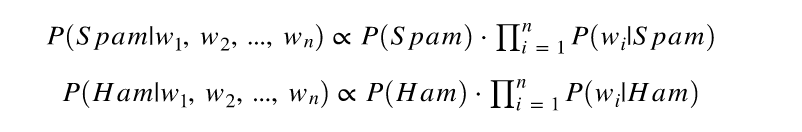

Inorder to calculate the conditional probabilities of words (given its a spam or not), we can use the formula shown below:
* Note that we will be using Laplace smoothing (alpha=1) for sample correction. We are using a correction to avoid a probability value to become zero just because probability of one of the words in the comment is zero (Since we perform multiplication). Check [this]("https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf") blog out for a better explaination.

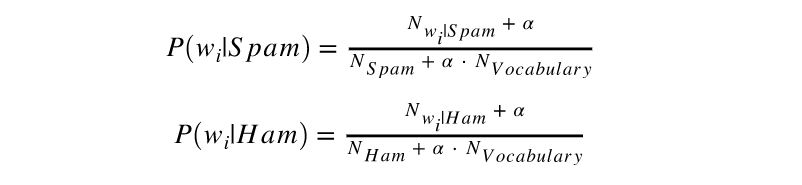

Now let's get the unique words and perform the required calculations

In [20]:
vocab=[]
for comment in df["CONTENT"]:
    for word in comment.split():
        vocab.append(word)

In [21]:
vocabulary=list(set(vocab))
len(vocabulary)

3363

In [22]:
# Create a column for each of the unique word in our vocabulary inorder to get the count of words 
for word in vocabulary:
    df[word]=0

In [23]:
df.head()

CONTENT  CLASS  ...  linked  renewal
0  huh  anyway check out this you tube  channel  ...      1  ...       0        0
1  hey guys check out my new channel and our firs...      1  ...       0        0
2               just for test i have to say htmllink      1  ...       0        0
3    me shaking my sexy ass on my channel enjoy  _        1  ...       0        0
4                        htmllink   check this out        1  ...       0        0

[5 rows x 3365 columns]

In [24]:
# looping through data frame and counting words 
for index,value in enumerate(df["CONTENT"]):
  for l in value.split():
    df[l][index]+=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
df.head()

CONTENT  CLASS  ...  linked  renewal
0  huh  anyway check out this you tube  channel  ...      1  ...       0        0
1  hey guys check out my new channel and our firs...      1  ...       0        0
2               just for test i have to say htmllink      1  ...       0        0
3    me shaking my sexy ass on my channel enjoy  _        1  ...       0        0
4                        htmllink   check this out        1  ...       0        0

[5 rows x 3365 columns]

In [26]:
#Total number of words in each class
df.groupby("CLASS").sum().sum(axis=1)

CLASS
0     7417
1    15560
dtype: int64

In [27]:
# Assign variables to all values required in calculation
p_ham=0.47604
p_spam=0.52396
n_spam=df[df["CLASS"]==1].drop(columns=["CONTENT","CLASS"]).sum().sum()
n_ham=df[df["CLASS"]==0].drop(columns=["CONTENT","CLASS"]).sum().sum()
n_vocabulary=len(vocabulary)

In [28]:
# Slicing dataframe for each class
df_sspam=df[df["CLASS"]==1]
df_hham=df[df["CLASS"]==0]

Let's create dictionaries to store probabilities of each word in dataframe given its a spam and not spam, so that we can reference values when required

In [29]:
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}
for word in vocabulary:
    n_word_given_spam = df_sspam[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + 1) / (n_spam + 1*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    n_word_given_ham = df_hham[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + 1) / (n_ham + 1*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

# 3. Model Testing

Let's create a function to clean a comment as we did before, calculate probabilities and return the predicted class of that comment

In [30]:
def classifier(string):
    message=html.unescape(string)
    message=string.replace("\ufeff","")
    message=string.replace("(<a.+>)","htmllink")
    message=string.replace("\'|<.+>","")
    message=string.replace("\S*\.com\S*|\S*watch\?\S*","htmllink")
    message=string.replace("\W"," ").lower()
    p_string_s=1
    p_string_h=1
    for word in message.split():
        if word in parameters_spam:
            p_string_s*=parameters_spam[word]
            p_string_h*=parameters_ham[word]
    if (p_string_s*p_spam)>(p_string_h*p_ham):
        return(1)
    elif (p_string_s*p_spam)<(p_string_h*p_ham):
        return(0)
    else:
        return(-1)

In [31]:
# Reading the dataframe for testing model
df_shakira=pd.read_csv("/content/drive/My Drive/Google colab data/Youtube spam/Youtube05-Shakira.csv")

In [32]:
df_shakira.head()

COMMENT_ID  ... CLASS
0    z13lgffb5w3ddx1ul22qy1wxspy5cpkz504  ...     0
1      z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj  ...     0
2  z12quxxp2vutflkxv04cihggzt2azl34pms0k  ...     0
3      z12icv3ysqvlwth2c23eddlykyqut5z1h  ...     0
4      z133stly3kete3tly22petvwdpmghrlli  ...     0

[5 rows x 5 columns]

In [33]:
df_shakira["Pred_Class"]=df_shakira["CONTENT"].apply(classifier)

In [34]:
correct_predictions=0
total_rows=0
for row in df_shakira.iterrows():
    row=row[1]
    total_rows+=1
    if row["CLASS"]==row["Pred_Class"]:
        correct_predictions+=1
accuracy=correct_predictions/total_rows
print("accuracy=",accuracy)


accuracy= 0.8432432432432433


Our model classified ~85% of the comments correctly. Considering the simplicity of this algorithm, it is a really useful classification model, which is often used in Natural Language processing (NLP) problems

However, one of the major drawbacks of naive-bayes classifier is that it does not consider the relationship between features. 